# 📘 Loan Default Prediction with SHAP Explainability

In [17]:

# ---  IMPORTS & LOAD DATA ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Excel file (with two sheets)
file_path = '/content/drive/MyDrive/GitHub/loan_data.xlsx'
xls = pd.ExcelFile(file_path)
print("Available sheets:", xls.sheet_names)
df = xls.parse('Data')
print(df.shape)
df.head()

Available sheets: ['Description', 'Data']
(5000, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


## 🔍 Step 1: Dataset Overview & Initial Exploration

Before jumping into modeling, it's crucial to understand what we’re working with.

We’ll:
- Check dataset size and structure
- Identify missing values
- Understand the target variable distribution

This sets the foundation for our preprocessing and modeling steps.


In [18]:
# Basic structural info
df.info()

# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("Missing Values:\n", missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB
Missing Values:
 Series([], dtype: int64)


## 🎯 Understanding the Target Variable

Let’s look at the target variable we’re trying to predict.  
We'll check how balanced the classes are — if it's too imbalanced, we may need techniques like SMOTE or class weights later.


In [20]:
# See all column names
print(df.columns.tolist())

['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']


In [21]:
# Replace with your actual target column name if different
target_col = 'Personal Loan'
df[target_col].value_counts()


,count
Personal Loan,
0,4520
1,480


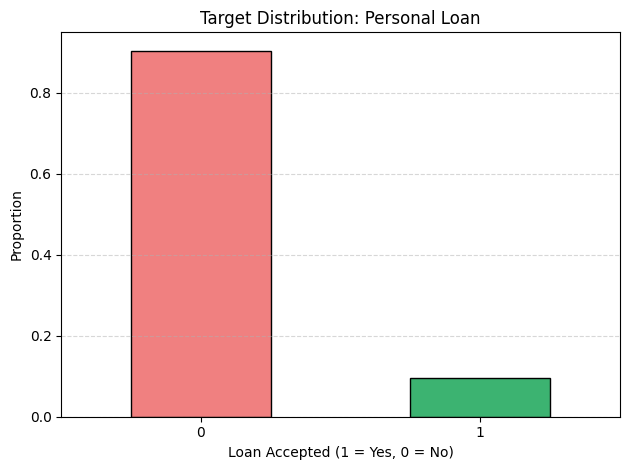

In [22]:
import matplotlib.pyplot as plt

# Target distribution visualization
target_col = 'Personal Loan'
plot_path = '/content/drive/MyDrive/GitHub/assets/target_distribution_personal_loan.png'

df[target_col].value_counts(normalize=True).plot(
    kind='bar',
    color=['lightcoral', 'mediumseagreen'],
    edgecolor='black'
)

plt.title('Target Distribution: Personal Loan')
plt.xlabel('Loan Accepted (1 = Yes, 0 = No)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()

## 🧼 Step 2: Data Preprocessing

Before modeling, we need to clean and prepare the data.  
Here’s what we’ll do:

- 🔹 Drop non-informative features (like ZIP Code)
- 🔹 Encode categorical variables (like Education)
- 🔹 Scale numerical features if needed
- 🔹 Split the data into training and testing sets

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Drop non-informative features
df_model = df.drop(columns=['ZIP Code'])

# 2. One-hot encode categorical column (Education is ordinal, but for simplicity we encode)
df_model = pd.get_dummies(df_model, columns=['Education'], drop_first=True)

# 3. Define features and target
X = df_model.drop(columns=['Personal Loan'])  # All other columns
y = df_model['Personal Loan']                # Target

# 4. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Scale numeric features (standard scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## ⚙️ Step 3: Baseline Modeling (Logistic Regression)

We’ll start with a Logistic Regression model to establish a baseline.

Why Logistic Regression?
- It's interpretable and fast
- A great sanity check before advanced models
- If this works well, our features are meaningful


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 2. Predict
y_pred = lr_model.predict(X_test_scaled)
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# 3. Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       904
           1       0.85      0.70      0.77        96

    accuracy                           0.96      1000
   macro avg       0.91      0.84      0.87      1000
weighted avg       0.96      0.96      0.96      1000

ROC AUC Score: 0.9617786688790562


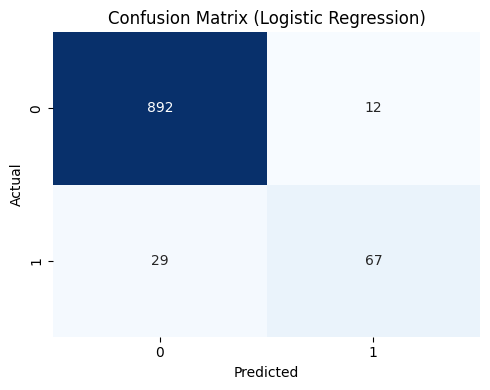

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/GitHub/assets/logreg_confusion_matrix.png", dpi=300)
plt.show()

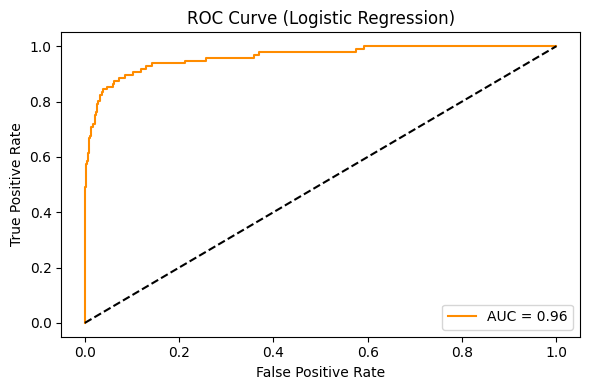

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/GitHub/assets/logreg_roc_curve.png", dpi=300)
plt.show()


## 🚀 Step 4: Advanced Modeling with XGBoost

After establishing our baseline with Logistic Regression, we now train a more powerful model using **XGBoost**.

Why XGBoost?
- Handles **nonlinear relationships** well
- Supports **class imbalance adjustments**
- Works seamlessly with **SHAP** for explainability

Let’s train, evaluate, and compare the performance!


In [27]:
!pip install xgboost --quiet

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Define XGBoost model with basic parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle imbalance
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [28]:
# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC Score (XGBoost):", roc_auc_score(y_test, y_proba_xgb))

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       904
           1       0.91      0.98      0.94        96

    accuracy                           0.99      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.99      0.99      0.99      1000

ROC AUC Score (XGBoost): 0.9990896939528024


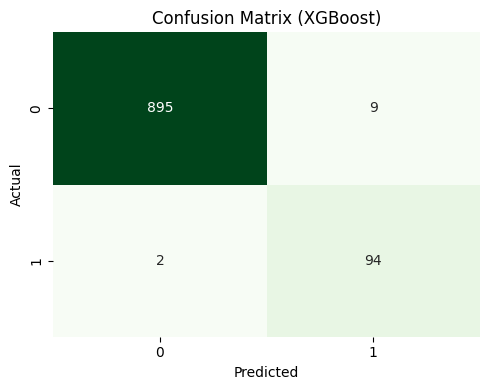

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/GitHub/assets/xgb_confusion_matrix.png", dpi=300)
plt.show()

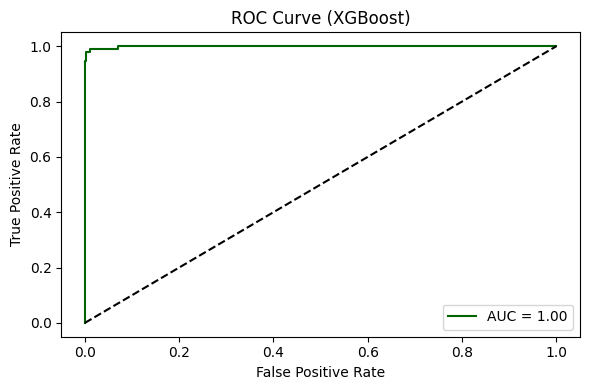

In [30]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_score(y_test, y_proba_xgb):.2f}", color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/GitHub/assets/xgb_roc_curve.png", dpi=300)
plt.show()

## 🧠 Step 5: Model Explainability with SHAP

Great performance is only half the story — we need to know *why* the model behaves the way it does.  
In this step, we use **SHAP (SHapley Additive exPlanations)** to explain both global and individual decisions made by our XGBoost model.



### 🔍  Why SHAP?

- SHAP assigns each feature a *contribution score* per prediction
- Helps us move beyond accuracy to **model trust and auditability**
- We use `TreeExplainer` — optimized for gradient boosting models

---


In [31]:
!pip install shap --quiet

import shap

# Explain using TreeExplainer (optimized for XGBoost)
explainer = shap.Explainer(xgb_model, X_test_scaled)

# Compute SHAP values for test set
shap_values = explainer(X_test_scaled)


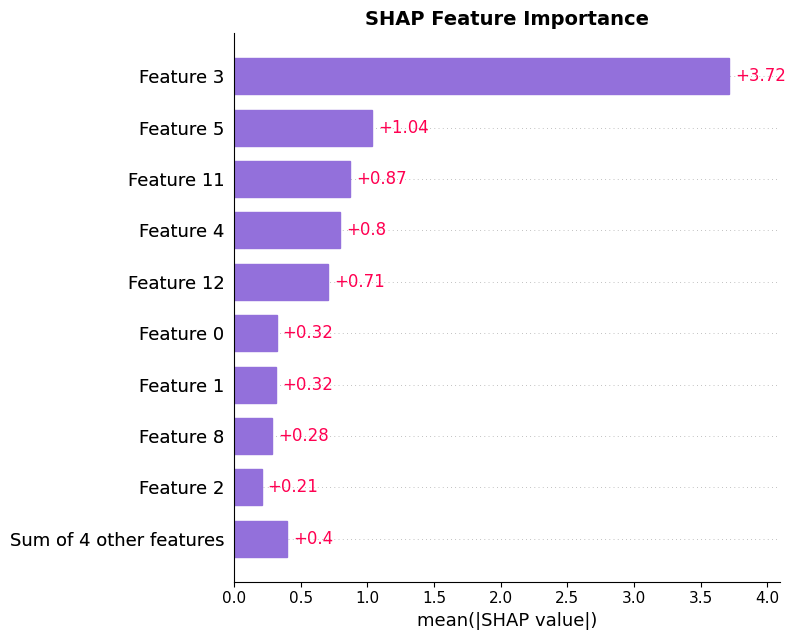

In [39]:
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use SHAP's matplotlib backend
shap.plots.bar(shap_values, max_display=10, show=False)

# Manually set purple theme
fig = plt.gcf()
ax = plt.gca()
for bar in ax.patches:
    bar.set_color("mediumpurple")  # You can try 'orchid', 'darkorchid', etc.

# Style
plt.title("SHAP Feature Importance", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/GitHub/assets/shap_summary_bar.png", dpi=300)
plt.show()


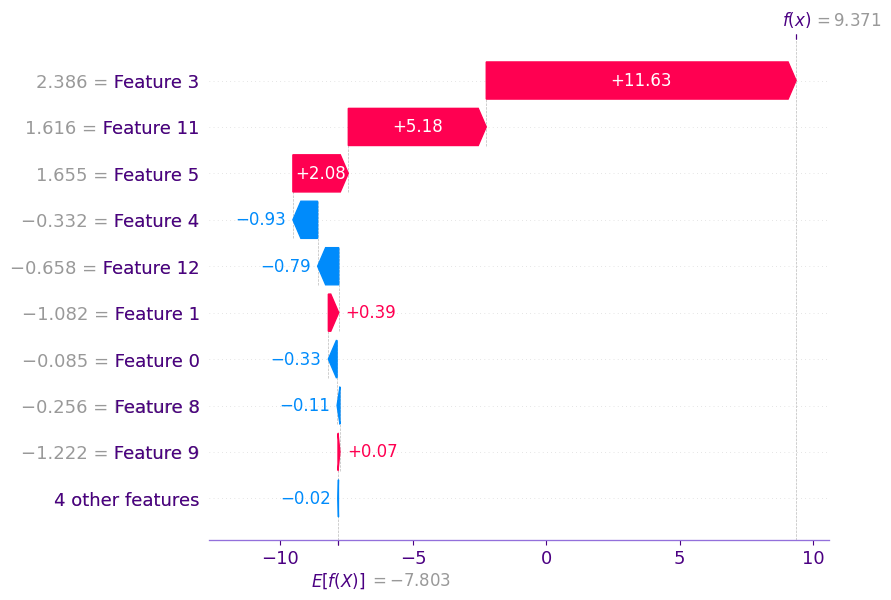

In [44]:
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl

# Step 1: Reset test set index
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Step 2: Get SHAP values
shap_values = explainer(X_test_scaled)

# Step 3: Pick a positive sample
sample_index = list(y_test_reset[y_pred_xgb == 1].index)[0]

# Step 4: Set visual theme
mpl.rcParams.update({
    'axes.edgecolor': '#9370DB',  # medium purple
    'text.color': '#4B0082',
    'axes.labelcolor': '#4B0082',
    'xtick.color': '#4B0082',
    'ytick.color': '#4B0082',
    'font.size': 11,
    'axes.titlesize': 14
})

# Step 5: Plot waterfall and store fig object
waterfall_plot = shap.plots.waterfall(shap_values[sample_index], max_display=10, show=False)

# Step 6: Save the SHAP decision plot
waterfall_plot.figure.savefig('/content/drive/MyDrive/GitHub/assets/shap_force_sample1.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
#Explanation
vals = shap_values[sample_index].values
features = X_test_reset.columns.tolist()
data = shap_values[sample_index].data

# Zip into readable format
explanation = sorted(zip(features, data, vals), key=lambda x: abs(x[2]), reverse=True)

print("Top Reasons for Prediction:")
for feat, val, impact in explanation[:5]:
    direction = "increased" if impact > 0 else "decreased"
    print(f"- {feat}: {val:.2f} → {direction} prediction by {abs(impact):.2f}")

Top Reasons for Prediction:
- Income: 2.39 → increased prediction by 11.63
- Education_2: 1.62 → increased prediction by 5.18
- CCAvg: 1.66 → increased prediction by 2.08
- Family: -0.33 → decreased prediction by 0.93
- Education_3: -0.66 → decreased prediction by 0.79


## 🤖 Model's Decision Reasoning (via SHAP)

Why did the model approve this loan?

- 🧑 **Income** = 2.39 → Strongly **increased** the likelihood
- 💾 **CD Account** = 1 → Indicates financial stability
- 💳 **CreditCard** = 1 → Slightly improved credibility
- 🏠 **Mortgage** = 0.01 → Very low, slightly decreased risk
- 👨‍👩‍👧 **Family** = 4 → Larger families may imply stable responsibilities

> ✅ This prediction wasn't a black box. SHAP helped us understand the *why* behind the result.
